# Analyzing Spotify Music Artist data 

**Description:**
In this Jupyter notebook, I delve into a data analysis, with my primary goal being to analyze a dataset about Spotify Songs and Music Artists and then enrich it with country statistics data, which i downloaded from Kaggle. I will try to unearth some insights and patterns concealed within the data. Through the application of different data analysis concepts and visualization principles, I aim to gain a deeper understanding of the information and try to answer the following questions: 

**1. What does the network of music artists and associated feature artists look like? Which artist has the biggest network of feature artists?**

**2. Can we predict track popularity using regression models?**

**3. How does the genre distribution by country look like? I.e. artists from which countries tend to create what kind of music? Can we build clusters?**

**4. Are there any interesting correlations between some music genres and specific countries and the related country statistics? **

Please be aware that the outcomes of this analysis are subject to various uncertainties and limitations. The results are based on available data and analytical methods, and I cannot guarantee their accuracy or complete representation of real-world relationships. Additionally, I acknowledge uncertainty regarding the effectiveness of my chosen analytical approaches.

# 0. Data Exploration

The first step will be to load the different datasets and get an overview of the data at hand.

In [1]:
# Load packages 
import pandas as pd 
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import geopandas as gpd
import plotly.express as px
import difflib

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Load data Artists dataset
path = "artists_shortened.csv"
df_artists = pd.read_csv(path, encoding='utf-8')

# Load data Spotify dataset
path = "Spotify_Global_50.csv"
df_spotify = pd.read_csv(path, encoding='latin1')

# Load world statistics data
path = "world-data-2023.csv"
df_country = pd.read_csv(path, encoding='utf-8')

# Spotify Dataset

The dataset contains information about the top 50 most streamed songs on Spotify, including their track name, artist name, album name, release date, duration, popularity, explicit lyrics, and images of the album cover art.

In [3]:
# Quick overview Spotify data
print("\nSpotify dataset overview:")
print(df_spotify.info())
print(df_spotify.describe())
display(df_spotify.head())


Spotify dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11700 entries, 0 to 11699
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   track_name                    11700 non-null  object
 1   track_add_date                11700 non-null  object
 2   track_add_time                11700 non-null  object
 3   multiple_artists_bool         11700 non-null  bool  
 4   name_of_artists               11700 non-null  object
 5   album_name                    11700 non-null  object
 6   album_release_date            11700 non-null  object
 7   album_release_date_precision  11700 non-null  object
 8   number_of_tracks_in_album     11700 non-null  int64 
 9   position_in_playlist          11700 non-null  int64 
 10  track_duration_ms             11700 non-null  int64 
 11  track_popularity              11700 non-null  int64 
 12  track_explicit                11700 non-null  b

track_name track_add_date track_add_time  multiple_artists_bool  \
0             Flowers     2023-03-31       10:02:16                  False   
1           Kill Bill     2023-03-31       10:02:16                  False   
2                 TQG     2023-03-31       10:02:16                   True   
3                BESO     2023-03-31       10:02:16                   True   
4  Boy's a liar Pt. 2     2023-03-31       10:02:16                   True   

                   name_of_artists               album_name  \
0                  ['Miley Cyrus']  Endless Summer Vacation   
1                          ['SZA']                      SOS   
2           ['KAROL G', 'Shakira']     MAÃANA SERÃ BONITO   
3   ['ROSALÃA', 'Rauw Alejandro']                       RR   
4  ['PinkPantheress', 'Ice Spice']       Boy's a liar Pt. 2   

  album_release_date album_release_date_precision  number_of_tracks_in_album  \
0         2023-03-10                          day                         13   
1         2022-12-08                          day                         23   
2         2023-02-24                          day                         17   
3         2023-03-24                          day                          3   
4         2023-02-03                          day                          2   

   position_in_playlist  track_duration_ms  track_popularity  track_explicit  \
0                     1             200600                87           False   
1                     2             153946                94           False   
2                     3             197933                97            True   
3                     4             194543                87           False   
4                     5             131013                97           False   

                                    images_path data_collection_date  
0              ./images/flowers_miley_cyrus.jpg           2023-03-31  
1                    ./images/kill_bill_sza.jpg           2023-03-31  
2                      ./images/tqg_karol_g.jpg           2023-03-31  
3                      ./images/beso_rosala.jpg           2023-03-31  
4  ./images/boys_a_liar_pt_2_pinkpantheress.jpg           2023-03-31

# Country Statistics Dataset

This comprehensive dataset provides a wealth of information about all countries worldwide, covering a wide range of indicators and attributes. It encompasses demographic statistics, economic indicators, environmental factors, healthcare metrics, education statistics, and much more. With every country represented, this dataset offers a complete global perspective on various aspects of nations, enabling in-depth analyses and cross-country comparisons.

In [4]:
# Quick overview World statistics data
print("\nWorld statistics dataset overview:")
print(df_country.info())
print(df_country.describe())
display(df_country.head())


World statistics dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                            195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    obj

Country Density\n(P/Km2) Abbreviation Agricultural Land( %)  \
0  Afghanistan               60           AF                58.10%   
1      Albania              105           AL                43.10%   
2      Algeria               18           DZ                17.40%   
3      Andorra              164           AD                40.00%   
4       Angola               26           AO                47.50%   

  Land Area(Km2) Armed Forces size  Birth Rate  Calling Code  \
0        652,230           323,000       32.49          93.0   
1         28,748             9,000       11.78         355.0   
2      2,381,741           317,000       24.28         213.0   
3            468               NaN        7.20         376.0   
4      1,246,700           117,000       40.73         244.0   

  Capital/Major City Co2-Emissions     CPI CPI Change (%) Currency-Code  \
0              Kabul         8,672   149.9          2.30%           AFN   
1             Tirana         4,536  119.05          1.40%           ALL   
2            Algiers       150,006  151.36          2.00%           DZD   
3   Andorra la Vella           469     NaN            NaN           EUR   
4             Luanda        34,693  261.73         17.10%           AOA   

   Fertility Rate Forested Area (%) Gasoline Price                GDP  \
0            4.47             2.10%         $0.70    $19,101,353,833    
1            1.62            28.10%         $1.36    $15,278,077,447    
2            3.02             0.80%         $0.28   $169,988,236,398    
3            1.27            34.00%         $1.51     $3,154,057,987    
4            5.52            46.30%         $0.97    $94,635,415,870    

  Gross primary education enrollment (%)  \
0                                104.00%   
1                                107.00%   
2                                109.90%   
3                                106.40%   
4                                113.50%   

  Gross tertiary education enrollment (%)  Infant mortality      Largest city  \
0                                   9.70%              47.9             Kabul   
1                                  55.00%               7.8            Tirana   
2                                  51.40%              20.1           Algiers   
3                                     NaN               2.7  Andorra la Vella   
4                                   9.30%              51.6            Luanda   

   Life expectancy  Maternal mortality ratio Minimum wage Official language  \
0             64.5                     638.0       $0.43             Pashto   
1             78.5                      15.0       $1.12           Albanian   
2             76.7                     112.0       $0.95             Arabic   
3              NaN                       NaN       $6.63            Catalan   
4             60.8                     241.0       $0.71         Portuguese   

  Out of pocket health expenditure  Physicians per thousand  Population  \
0                           78.40%                     0.28  38,041,754   
1                           56.90%                     1.20   2,854,191   
2                           28.10%                     1.72  43,053,054   
3                           36.40%                     3.33      77,142   
4                           33.40%                     0.21  31,825,295   

  Population: Labor force participation (%) Tax revenue (%) Total tax rate  \
0                                    48.90%           9.30%         71.40%   
1                                    55.70%          18.60%         36.60%   
2                                    41.20%          37.20%         66.10%   
3                                       NaN             NaN            NaN   
4                                    77.50%           9.20%         49.10%   

  Unemployment rate Urban_population   Latitude  Longitude  
0            11.12%        9,797,273  33.939110  67.709953  
1            12.33%        1,747,593  41.1

# Music Artist Popularity Data set

The original dataset consists of over 1.4 Million musical artists present in MusicBrainz database -- their names, tags, and popularity (listeners/scrobbles), based on data scraped from last.fm. For the purpose of this project, I had to shorten it.

I will mainly try to use it to enrich the spotify data with the nationality of the artists in order to then merge with the country statistics. 

In [5]:
# Quick overview Artists data
print("Artists dataset overview:")
print(df_artists.info())
print(df_artists.describe())
display(df_artists.head())

Artists dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  200000 non-null  int64 
 1   artist_mb   199995 non-null  object
 2   country_mb  127888 non-null  object
 3   tags_mb     44077 non-null   object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB
None
          Unnamed: 0
count  200000.000000
mean    99999.500000
std     57735.171256
min         0.000000
25%     49999.750000
50%     99999.500000
75%    149999.250000
max    199999.000000


Unnamed: 0              artist_mb      country_mb  \
0           0               Coldplay  United Kingdom   
1           1              Radiohead  United Kingdom   
2           2  Red Hot Chili Peppers   United States   
3           3                Rihanna   United States   
4           4                 Eminem   United States   

                                                                                                                                                                                                                                                tags_mb  
0                                                                     rock; pop; alternative rock; british; uk; britannique; britpop; pop rock; piano pop; piano rock; english; parlophone; rock and indie; ambient pop; pop/rock; chapel; post-britpop  
1  rock; electronic; alternative rock; british; grunge; uk; britannique; britpop; art rock; experimental rock; english; chamber pop; parlophone; england; melancholic; oxford; bootleg; rock and indie; c’était mieux avant; art pop; nude; sacred cows  
2                                                                 rock; alternative rock; 80s; 90s; rap; metal; american; crossover; usa; funk; funk rock; alternative; pop rock; funk metal; rap rock; 00s; dvd; pop and chart; 10s; funk rock tributo  
3                                          pop; dance; hip hop; reggae; contemporary r b; electropop; rnb; barbadian; dance-pop; dancehall; electro house; pop and chart; pop soul; rihanna; barbadien; barbados; barbade; rehab; r&b; contemporary r&b  
4                                                         turkish; rap; american; hip-hop; hip hop; hiphop; midwest hip-hop; detroit hip-hop; pop rap; horrorcore; rapper; us; pop and chart; eminem; 8 mile; boom bap; v; comedy rap; hardcore hip hop

# 1. Feature extraction and cleansing
After the first inspection it looks like the datasets are all already pretty clean, which is rare to find in real world data. 

Now I will try to extract the main artists and feature artists for each song from the Spotify data. For simplicity, I will assume that the first artist in the list is the main artists and all other artists displayed in each list are Feature artists.

In [6]:
df_spotify.shape

(11700, 15)

In [7]:
# Rename df_spotify to df for a while 
df = df_spotify

In [8]:
# Convert the strings to actual lists
df['name_of_artists'] = df['name_of_artists'].apply(ast.literal_eval)

# Extract all feature artists into a new column
df['name_of_feature_artists'] = df.name_of_artists.apply(lambda x: x[1::])

# Reposition the column next to name_of_artists
column_to_move = 'name_of_feature_artists'
target_position = 5
df.insert(target_position, column_to_move, df.pop(column_to_move))

# Now only keep the first artist in name_of_artists
df['name_of_artists'] = df['name_of_artists'].apply(lambda x: x[0:1])

# Remove the lists, if it is just one artist and if the list is empty insert a nan value
df["name_of_artists"] = df["name_of_artists"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df["name_of_feature_artists"] = df["name_of_feature_artists"].apply(lambda x: x if isinstance(x, list) and len(x) > 1 else (x[0] if isinstance(x, list) and len(x) == 1 else np.nan))

# 2. Network Analysis

The following code creates a network graph based on prior adjustments I did to the data to visualize artist collaborations. It adds artists as nodes, establishes connections for collaborations, calculates node degrees, and removes isolated nodes. The graph is visualized with node sizes and colors, using a black background and a colorbar legend for node degrees. I did not include the nodes from artists in the graph, that have no features, because it made the layout a lot more complex.

/usr/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning:

Glyph 152 missing from current font.

/usr/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning:

Glyph 152 missing from current font.



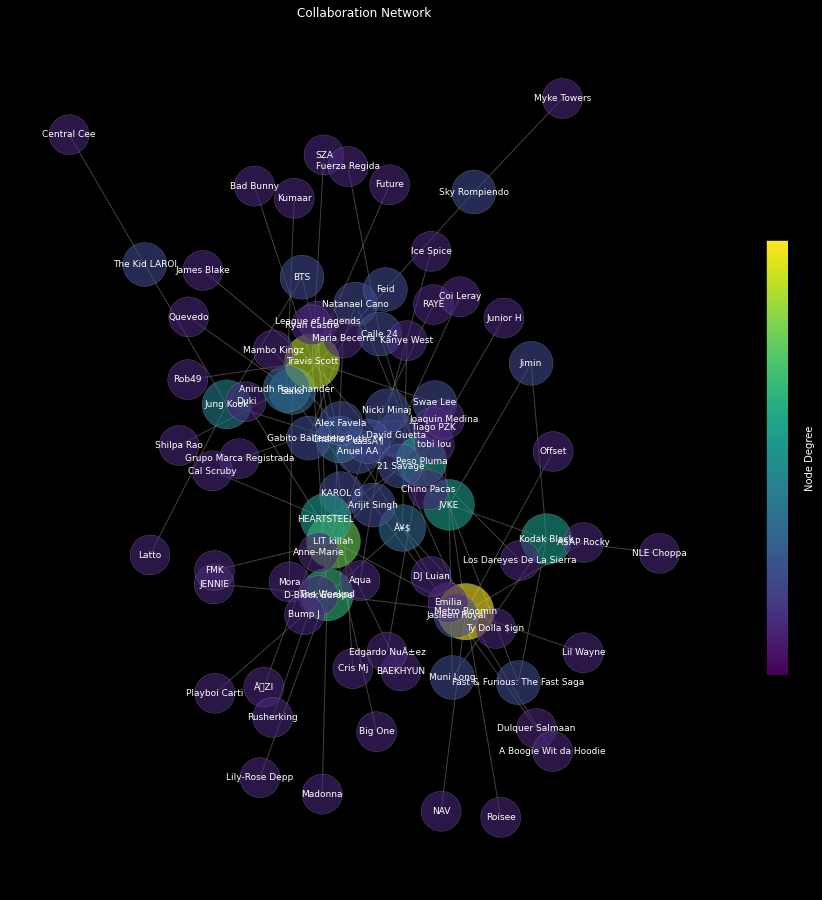

In [9]:
# Create a network graph
G = nx.Graph()

# Add nodes (artists) to the graph
G.add_nodes_from(df["name_of_artists"])

# Deduplicate and flatten the "name_of_feature_artists" column
all_feature_artists = []
for artists_list in df["name_of_feature_artists"]:
    if isinstance(artists_list, list):
        all_feature_artists.extend(artists_list)
        
all_feature_artists = set(all_feature_artists)
    
# Add nodes (feature artists) to the graph from the "name_of_feature_artists" column    
G.add_nodes_from(all_feature_artists)

for _, row in df.iterrows():
    artist = row["name_of_artists"]
    feature_artists = row["name_of_feature_artists"]

    if not artist == None:  # Check for NaN in the artist column
        if isinstance(feature_artists, list):
            for feature_artist in feature_artists:
                if not feature_artist == None:  # Check for NaN in feature artists
                    G.add_edge(artist, feature_artist)

# Calculate the degrees of all nodes
node_degrees = dict(G.degree())

# Identify nodes with zero degree (no edges) and remove them
isolated_nodes = [node for node, degree in node_degrees.items() if degree == 0]
G.remove_nodes_from(isolated_nodes)

# Define a list of sizes for nodes based on their degrees and the figure size
figure_size = (16, 16)  
node_sizes = [800 + 800 * np.sqrt(node_degrees[node]) for node in G.nodes()]

# Create a color map for nodes based on their degrees
cmap = plt.cm.get_cmap('viridis')
node_colors = [cmap(node_degrees[node] / max(node_degrees.values())) for node in G.nodes()]

# Visualize the network graph 
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=figure_size, facecolor='black')  
ax = plt.gca()
ax.set_facecolor('black')  

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')

# Draw nodes with labels
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap=cmap,
    alpha=0.6,
    linewidths=0.2,
    edgecolors='white',  
)
labels = {node: node for node in G.nodes()} 
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='white')  

plt.title("Collaboration Network", color='white')  

# Create a colorbar legend for node sizes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_degrees.values()), vmax=max(node_degrees.values())))
sm._A = []
cbar = plt.colorbar(sm, shrink=0.5, aspect=20)
cbar.set_label('Node Degree', color='white')  

plt.axis('off')  
plt.show()

In [10]:
# Calculate the degrees of all artist nodes
artist_degrees = {node: degree for node, degree in node_degrees.items() if node in df["name_of_artists"].tolist()}

# Sort artist nodes by degree in descending order
sorted_artist_degrees = sorted(artist_degrees.items(), key=lambda x: x[1], reverse=True)

# Print or visualize the top N artists with the most features
top_n = 10  
top_artists = sorted_artist_degrees[:top_n]

print("Top Artists with the Most Features:")
for artist, degree in top_artists:
    print(f"{artist}: {degree} features")

Top Artists with the Most Features:
Metro Boomin: 9 features
Travis Scott: 8 features
LIT killah: 7 features
The Weeknd: 6 features
Peso Pluma: 5 features
JVKE: 5 features
Kodak Black: 5 features
HEARTSTEEL: 5 features
Jung Kook: 4 features
Saiko: 3 features


## 3D Network Analysis with Plotly

Because I had some issues in the prior graph to make sure that all of the nodes don't overlap, I thought I could give 3D Network Analysis Tools a try. I found online, that Plotly provides some good features for this. Although this would look more beautiful with even more data, I think it solves the issue of overlapping nodes, as you can scroll in and out dynamically. 

In [11]:
# Calculate the positions of the nodes in 3D space
pos = nx.spring_layout(G, dim=3)

# Calculate node degrees
node_degrees = dict(G.degree())

# Extract the coordinates of each node
x_nodes = [pos[node][0] for node in G.nodes()]  # x-coordinates
y_nodes = [pos[node][1] for node in G.nodes()]  # y-coordinates
z_nodes = [pos[node][2] for node in G.nodes()]  # z-coordinates

# Define node sizes (larger size for nodes with more edges)
node_sizes = [5 + 10 * np.sqrt(node_degrees[node]) for node in G.nodes()]

# Custom color scale for nodes
color_scale = [
    [0.0, 'rgb(255, 255, 217)'],
    [0.5, 'rgb(237, 248, 177)'],
    [1.0, 'rgb(1, 102, 94)']
]

# Node trace
trace_nodes = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(size=node_sizes, color=list(node_degrees.values()), colorscale=color_scale, showscale=True),
    text=[node for node in G.nodes()],
    textposition='top center',
    hoverinfo='text'
)

# Edge trace
edge_traces = []

for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    trace_edges = go.Scatter3d(
        x=[x0, x1, None], y=[y0, y1, None], z=[z0, z1, None],
        mode='lines',
        line=dict(width=1, color='grey'),
        hoverinfo='none'
    )
    edge_traces.append(trace_edges)

# Layout
layout = go.Layout(
    title="3D Collaboration Network",
    width=1000, height=800, 
    showlegend=False,
    scene=dict(
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        zaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        bgcolor='rgba(0,0,0,0)'
    ),
    paper_bgcolor='rgba(0,0,0,0)',
)

# Combine node and edge traces
data = [trace_nodes] + edge_traces

# Create and show figure
fig = go.Figure(data=data, layout=layout)
fig.show()


# 3. Linear Regression - Predicting Track Popularity

In this code I am using linear regression to predict track popularity based on some track attributes. I perform some data preprocessing, feature selection, model training, and evaluation. Additionally, the code visualizes the most important features influencing track popularity. There are not too many features the code is trained on, so in the next step we will enrich the data with country statistics.


Mean Absolute Error: 5.9172985560745035


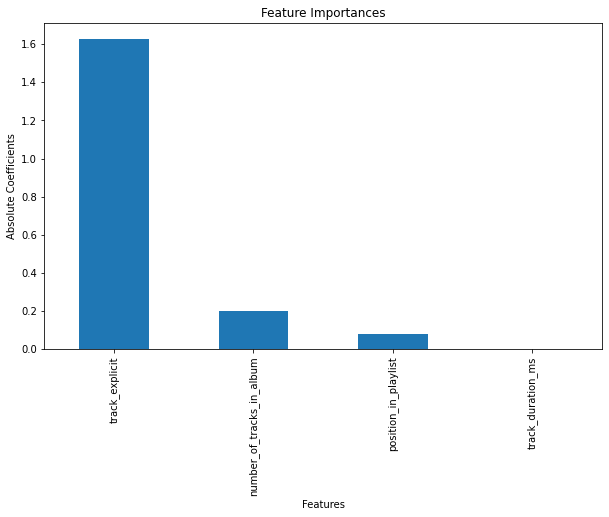

Most important features:
track_explicit               1.629486
number_of_tracks_in_album    0.197880
position_in_playlist         0.080630
track_duration_ms            0.000018
dtype: float64


In [12]:
# Perform one-hot encoding for categorical variables
data = pd.get_dummies(df, columns=['track_name', 'album_name'])

# Select features (excluding target variable)
features = ['number_of_tracks_in_album', 'position_in_playlist', 'track_duration_ms', 'track_explicit']
X = data[features]
y = data['track_popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE) as a performance metric
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Extract feature importances from the linear regression model
feature_importances = pd.Series(model.coef_, index=features)
feature_importances_abs = feature_importances.abs().sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances_abs.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficients')
plt.show()

# Show the most important features
print("Most important features:")
print(feature_importances_abs.head())

Interestingly, the explicitness of music tracks emerges as a prominent influencer in the model, particularly in predicting track popularity. The Mean Absolute Error (MAE) on the test data is quite low, indicating a high level of accuracy in the test data predictions. 

In order to see, wether there will be a difference in the prediction, I will also try running a RandomForestRegressor model:

Random Forest Mean Absolute Error: 2.9068185743755155


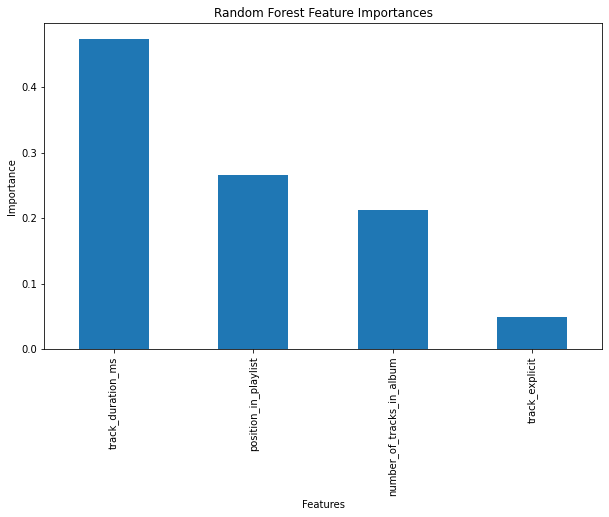

Most important features:
track_duration_ms            0.474159
position_in_playlist         0.265596
number_of_tracks_in_album    0.211817
track_explicit               0.048427
dtype: float64


In [13]:
# Train a Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE) as a performance metric for the Random Forest model
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest Mean Absolute Error: {mae}")

# Extract feature importances from the Random Forest model
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances_abs = feature_importances.abs().sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances_abs.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Show the most important features
print("Most important features:")
print(feature_importances_abs.head())

The Random Forest Regressor model yields a Mean Absolute Error (MAE) of approximately 2.91 on the test data, which is notably lower than the MAE achieved by the Linear Regression model (approximately 5.92). This lower MAE suggests that the Random Forest Regressor model provides more accurate predictions of track popularity.

The feature importances from the Random Forest Regressor model reveal that 'track_duration_ms' and 'position_in_playlist' are the most influential features in predicting track popularity, followed by 'number_of_tracks_in_album' and 'track_explicit.' It is interesting to see, that the feature 'track_explicit' doesn't seem to be as important as in the other model.

# 4. Merging data

Now, I will try to merge the Spotify and radio channel datasets to extract artist home countries and tags. I will then process the data by converting lists to strings, removing duplicates, and adding country statistics.

In [14]:
# Merge Spotify dataset with radio channel data set to extract the home countries of the artists, as well as some tags
df = df.merge(df_artists[['artist_mb', 'country_mb', 'tags_mb']], how = "left", left_on = 'name_of_artists', right_on= 'artist_mb')

# Deleting the lists, because that columns makes dropping duplicates not possible
df['name_of_feature_artists'] = df['name_of_feature_artists'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Drop duplicate data entries based on the modified column
df.drop_duplicates(inplace=True)

# Join the country statistics data to the main df
df = df.merge(df_country, how = "left", left_on = 'country_mb', right_on= 'Country')

After merging the data and trying to apply it again to the linear regression model, I realized that there are a lot of unnecessary signs in the country statistics data. So, we are going to clean it first.

In [15]:
# Define a function to clean and convert columns
def clean_and_convert(column):
    if column.dtype == 'object':
        # Remove commas, dollar signs, and percentages, and convert to numeric
        column = column.str.replace(',', '', regex=True)
        column = column.str.replace('$', '', regex=True)
        column = column.str.replace('%', '', regex=True)
        column = pd.to_numeric(column, errors='coerce')
    return column

# Apply the cleaning and conversion function to relevant columns
columns_to_clean = [
    'Agricultural Land( %)', 'Land Area(Km2)', 'Co2-Emissions', 'CPI', 'CPI Change (%)',
    'Fertility Rate', 'Forested Area (%)', 'Gasoline Price', 'GDP',
    'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)',
    'Minimum wage', 'Out of pocket health expenditure', 'Population',
    'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate',
    'Unemployment rate', 'Urban_population'
]

for column in columns_to_clean:
    df[column] = clean_and_convert(df[column])
    
for column in columns_to_clean:
    df_country[column] = clean_and_convert(df_country[column])

In [16]:
df.Country.value_counts()

United States     3560
United Kingdom    1051
Canada             755
Colombia           425
Netherlands        206
France             143
Germany             51
Australia           28
Sweden              26
India               26
South Korea          7
Chile                1
Italy                1
Name: Country, dtype: int64

In [17]:
df.head()

track_name track_add_date track_add_time  multiple_artists_bool  \
0             Flowers     2023-03-31       10:02:16                  False   
1           Kill Bill     2023-03-31       10:02:16                  False   
2                 TQG     2023-03-31       10:02:16                   True   
3                BESO     2023-03-31       10:02:16                   True   
4  Boy's a liar Pt. 2     2023-03-31       10:02:16                   True   

  name_of_artists name_of_feature_artists               album_name  \
0     Miley Cyrus                     NaN  Endless Summer Vacation   
1             SZA                     NaN                      SOS   
2         KAROL G                 Shakira     MAÃANA SERÃ BONITO   
3        ROSALÃA          Rauw Alejandro                       RR   
4  PinkPantheress               Ice Spice       Boy's a liar Pt. 2   

  album_release_date album_release_date_precision  number_of_tracks_in_album  \
0         2023-03-10                          day                         13   
1         2022-12-08                          day                         23   
2         2023-02-24                          day                         17   
3         2023-03-24                          day                          3   
4         2023-02-03                          day                          2   

   position_in_playlist  track_duration_ms  track_popularity  track_explicit  \
0                     1             200600                87           False   
1                     2             153946                94           False   
2                     3             197933                97            True   
3                     4             194543                87           False   
4                     5             131013                97           False   

                                    images_path data_collection_date  \
0              ./images/flowers_miley_cyrus.jpg           2023-03-31   
1                    ./images/kill_bill_sza.jpg           2023-03-31   
2                      ./images/tqg_karol_g.jpg           2023-03-31   
3                      ./images/beso_rosala.jpg           2023-03-31   
4  ./images/boys_a_liar_pt_2_pinkpantheress.jpg           2023-03-31   

     artist_mb     country_mb                          tags_mb        Country  \
0  Miley Cyrus  United States           rock; pop; miley-cyrus  United States   
1          SZA  United States  electronic; american; chillwave  United States   
2          NaN            NaN                              NaN            NaN   
3          NaN            NaN                              NaN            NaN   
4          NaN            NaN                              NaN            NaN   

  Density\n(P/Km2) Abbreviation  Agricultural Land( %)  Land Area(Km2)  \
0               36           US                   44.4       9833517.0   
1               36           US                   44.4       9833517.0   
2              NaN          NaN                    NaN             NaN   
3              NaN          NaN                    NaN             NaN   
4              NaN          NaN                    NaN             NaN   

  Armed Forces size  Birth Rate  Calling Code Capital/Major City  \
0         1,359,000        11.6           1.0   Washington, D.C.   
1         1,359,000        11.6           1.0   Washington, D.C.   
2               NaN         NaN           NaN                NaN   
3               NaN         NaN           NaN                NaN   
4               NaN         NaN           NaN                NaN   

   Co2-Emissions     CPI  CPI Change (%) Currency-Code  Fertility Rate  \
0      5006302.0  117.24             7.5           USD            1.73   
1      5006302.0  117.24             7.5           USD            1.73   
2            NaN     NaN             NaN           NaN             NaN   
3            NaN     NaN             NaN           NaN             NaN   
4            Na

Regrettably, I realized here that there is limited overlap between the artists in the radio station data and the Spotify dataset. Consequently, only a limited number of countries are being incorporated into the main dataframe. This also results in numerous missing values during the intended country statistics enrichment process. Unfortunately, this renders the dataset less suitable for further analysis, as the genre distribution by country and possible correlations to country statistics will be very limited. 

Therefore, from this point, I will continue to work only with the radio and country statistics dataset. 

# 5. Clustering Ambigious Genre Tags For Analzying Genre Distribution by Country

In order to determine the distribution of music genres by country, I will leverage the origin country information of the artists in the radio dataset. My approach involves analyzing which genres are most prevalent in each country. Given that the 'tags_mb' column contains numerous diverse and occasionally inaccurate tags, I will employ a vectorization technique to transform these tags into a structured format. 

Subsequently, I will utilize clustering algorithms to group similar tags together, allowing us to assign artists to these clusters. Finally, I will examine the genres associated with each cluster and identify the countries where these genres are most prominent.

In [18]:
# Merge df_artists and df_country
df_artists_cs = df_artists.merge(df_country, how = "left", left_on = "country_mb", right_on = "Country")

Here, I'll process and cluster music genre tags. I'll clean and standardize the genre tags, perform TF-IDF vectorization to convert them into numerical features, and then use K-Means clustering to group similar genres together. The resulting clusters will be assigned as genre labels for the artists in the dataset.

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Lowercase and replace semicolons with commas
df_artists_cs['genre_tags'] = df_artists_cs['tags_mb'].str.lower().str.replace(';', ',')

# Replace commas with spaces and split the tags into a list
df_artists_cs['genre_tags'] = df_artists_cs['genre_tags'].str.replace(',', ' ').str.split()

# Define a function to join non-empty tags and handle empty values
def join_non_empty_tags(tags):
    if isinstance(tags, list):
        return ' '.join(tag for tag in tags if tag)
    else:
        return ''  

# Apply the function
df_artists_cs['genre_tags'] = df_artists_cs['genre_tags'].apply(join_non_empty_tags)

# Drop rows with empty genre_tags
df_artists_cs = df_artists_cs.dropna(subset=['genre_tags'])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_artists_cs['genre_tags'])

# Clustering 
n_clusters = 10  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix)

# Assign genre tags based on clusters
df_artists_cs['genre'] = cluster_labels


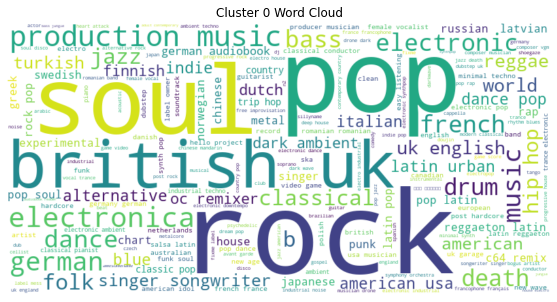

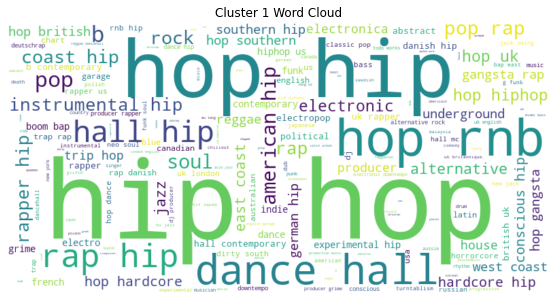

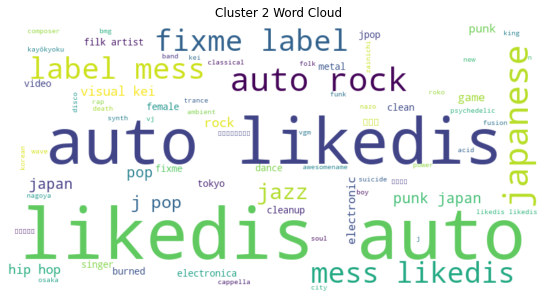

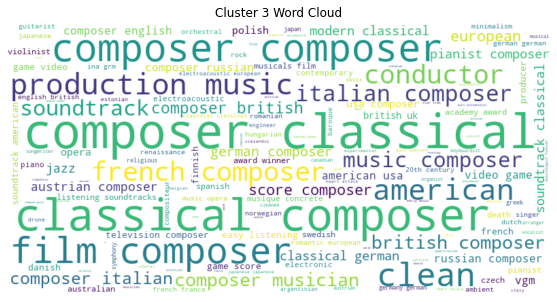

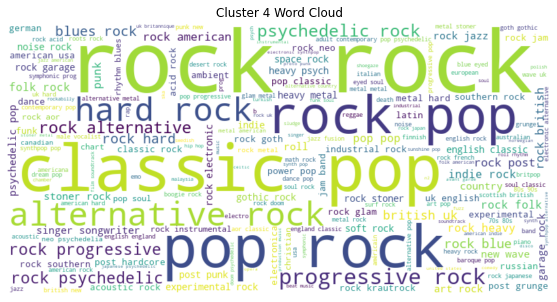

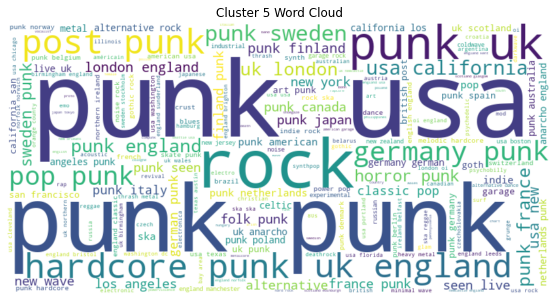

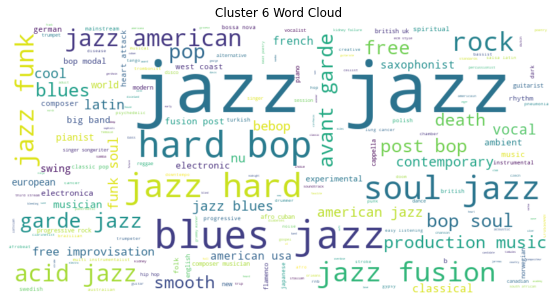

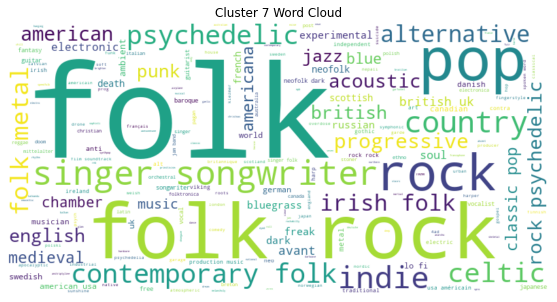

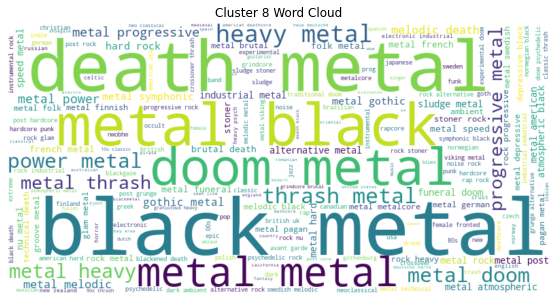

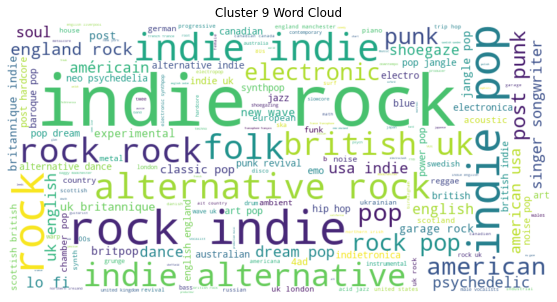

In [20]:
# Group artists by their cluster labels
clustered_artists = df_artists_cs.groupby('genre')

# Create word clouds for each cluster
for cluster_label, group in clustered_artists:
    tags_concatenated = ' '.join(group['genre_tags'])  # Concatenate all tags in the cluster
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_concatenated)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_label} Word Cloud')
    plt.axis('off')
    plt.show()


In [21]:
# Show which genre has the most artists creating it 
result = df_artists_cs.groupby('genre').size().reset_index(name='count')
result.sort_values(by = 'count', ascending = False)

genre   count
0      0  177677
4      4    5883
5      5    3359
8      8    3244
6      6    3059
1      1    2308
9      9    1539
7      7    1190
3      3    1077
2      2     664

In [22]:
# Group the data to see, which types of music are created in which 
# country and how many arists represent that cluster in each country
result = df_artists_cs.groupby(['Country', 'genre']).size().reset_index(name='count')
df_country_genre = result.groupby('Country', as_index = False).max('count')

# Join the country statistics data
df_country_genre = df_country_genre.merge(df_country, how = "left", on = 'Country')

When plotting the genre by Country in the follwoing, I realized that some of the country names are not matching. Therefore, I will try to identify which countries are not matching and adjust them, so they will match. 

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Identify differerences in the dataset country names
world_country_unique = world.name.unique()
df_country_unique = df_country_genre.Country.unique()

diff = list(set(world_country_unique) - set(df_country_unique))

In [24]:
import re

def find_matching_within_lists(list1, list2, min_matching_letters=3):
    matching_pairs = []

    for item1 in list1:
        for item2 in list2:
            # Use regex to find matches with at least min_matching_letters
            matches1 = re.findall(r'\w+', item1)
            matches2 = re.findall(r'\w+', item2)

            for match1 in matches1:
                for match2 in matches2:
                    if len(match1) >= min_matching_letters and len(match2) >= min_matching_letters:
                        if match1 == match2:
                            matching_pairs.append((item1, item2))

    return matching_pairs

list1 = diff
list2 = df_country_unique

# Specify the minimum number of matching letters
min_matching_letters = 3

# Find matching pairs
matching_pairs = find_matching_within_lists(list1, list2, min_matching_letters)

# Print the results
for pair in matching_pairs:
    print(f"Match found between '{pair[0]}' and '{pair[1]}'")


Match found between 'N. Cyprus' and 'Cyprus'
Match found between 'Dominican Rep.' and 'Dominican Republic'
Match found between 'Congo' and 'Democratic Republic of the Congo'
Match found between 'Eq. Guinea' and 'Equatorial Guinea'
Match found between 'Eq. Guinea' and 'Guinea'
Match found between 'Eq. Guinea' and 'Guinea-Bissau'
Match found between 'Eq. Guinea' and 'Papua New Guinea'
Match found between 'United States of America' and 'United Arab Emirates'
Match found between 'United States of America' and 'United Kingdom'
Match found between 'United States of America' and 'United States'
Match found between 'United States of America' and 'United States'
Match found between 'Dem. Rep. Congo' and 'Democratic Republic of the Congo'
Match found between 'North Korea' and 'South Korea'
Match found between 'New Caledonia' and 'New Zealand'
Match found between 'New Caledonia' and 'Papua New Guinea'
Match found between 'Bosnia and Herz.' and 'Antigua and Barbuda'
Match found between 'Bosnia and

In [25]:
# Change the names in the world dataframe
name_mappings = {
    'S. Sudan': 'South Sudan', 
    'United States of America': 'United States',
    'Congo': 'Democratic Republic of Congo', 
    'Bosnia and Herz.': 'Bosnia and Herzegovina', 
    'Dominican Rep.': 'Dominican Republic', 
    'Eq. Guinea' : 'Equatorial Guinea', 
    'N. Cyprus': 'Cyprus', 
    'Dem. Rep. Congo':'Democratic Republic of the Congo'
}
world['name'] = world['name'].replace(name_mappings)

In [26]:
# Load gpd dataset to visualize the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the data
merged_data = world.merge(df_country_genre, left_on='name', right_on='Country')

# Define a custom color scale 
custom_color_scale = [
    '#1f77b4',  # Genre 0
    '#ff7f0e',  # Genre 1
    '#2ca02c',  # Genre 2
    '#d62728',  # Genre 3
    '#9467bd',  # Genre 4
    '#8c564b',  # Genre 5
    '#e377c2',  # Genre 6
    '#7f7f7f',  # Genre 7
    '#bcbd22',  # Genre 8
    '#17becf'   # Genre 9
]

# Create a choropleth map 
fig = px.choropleth(
    merged_data,
    locations='iso_a3',
    color='genre',      
    hover_name='name',   
    hover_data=['count'],  
    title='Clustered Genres by Country',
    color_continuous_scale=custom_color_scale,  
    width=1000,  
    height=600   
)

# Customize the appearance of the map
fig.update_geos(
    projection_type='mercator',
    showcoastlines=True,
    coastlinecolor="Black",
    showland=True,
    landcolor="white"
)

# Update the layout 
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Genre",
        tickvals=list(range(10)), 
        ticktext=["Genre 0", "Genre 1", "Genre 2", "Genre 4", "Genre 5", "Genre 6", "Genre 7", "Genre 8", "Genre 9", "Genre 10"],  # Adjust labels
        ticks="outside"
    ),
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

# Show the interactive map
fig.show()


# 6. Analysis of Country Statistics Across Identified Genre Clusters

Now, I will examine the variations in country statistics concerning the identified genre clusters.

One acknowledged limitation here is the possibility that these genres might originate in the same countries, thus resulting in the data reflecting the characteristics of those particular countries to some extent.

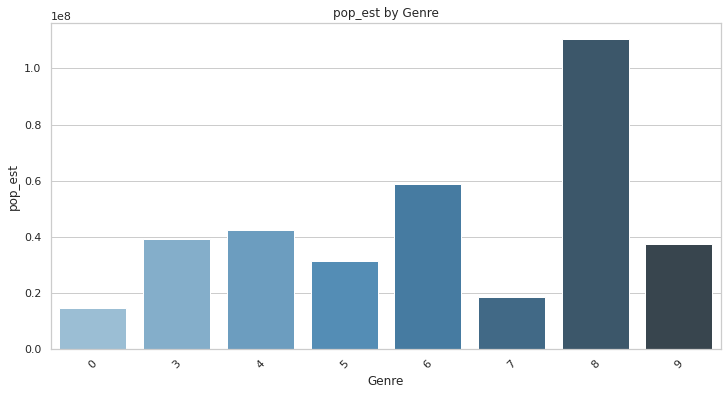

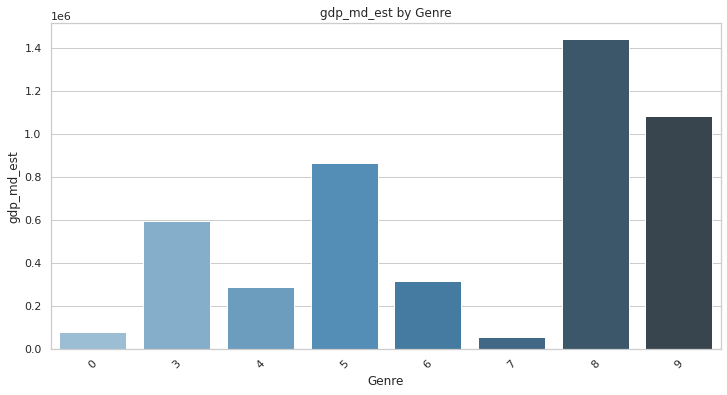

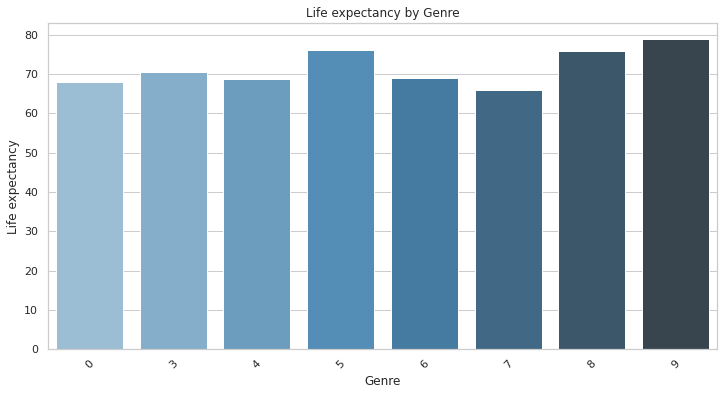

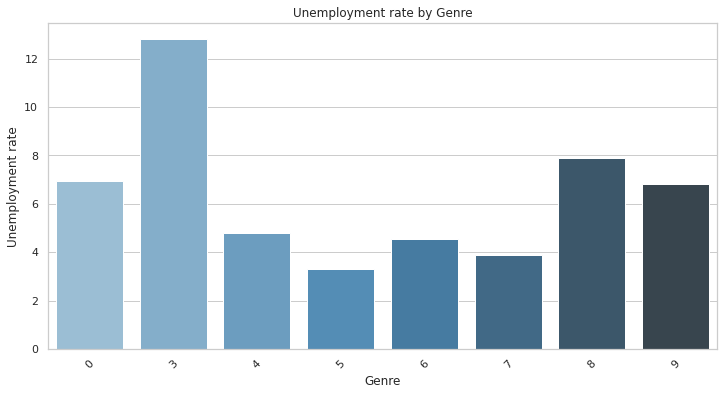

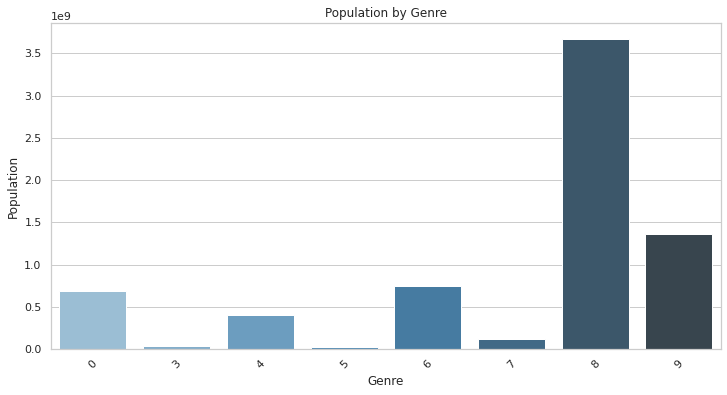

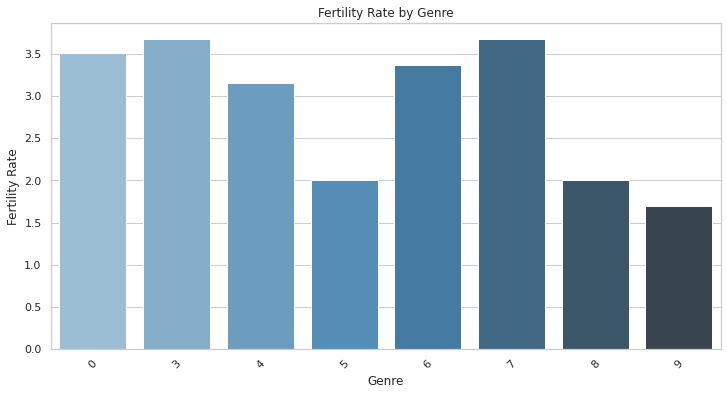

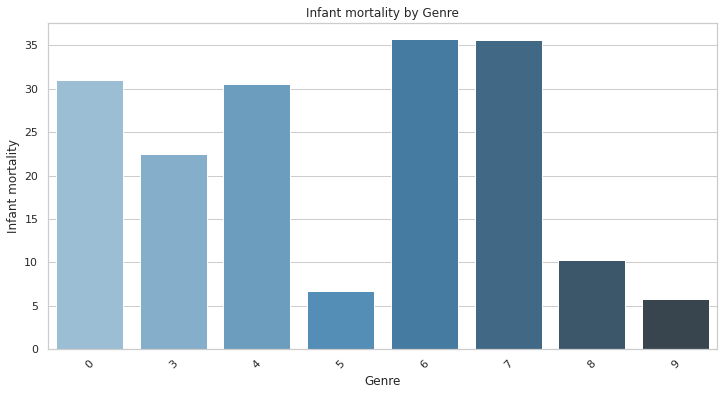

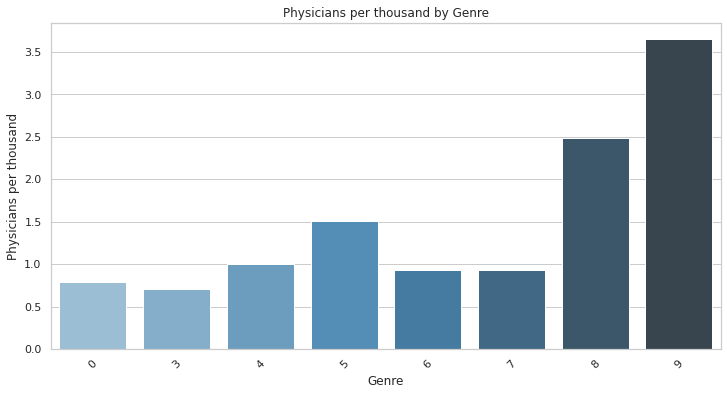

In [27]:
selected_columns = ['genre', 'pop_est', 'continent', 'gdp_md_est', 'Life expectancy', 'Unemployment rate', 'Population', 'Fertility Rate', 'Infant mortality', 'Physicians per thousand']

# Create a new DataFrame with selected columns
data = merged_data[selected_columns]

# Group and aggregate data
genre_stats = data.groupby('genre').agg({
    'pop_est': 'mean',
    'gdp_md_est': 'mean',
    'Life expectancy': 'mean',
    'Unemployment rate': 'mean',
    'Population': 'sum',
    'Fertility Rate': 'mean',
    'Infant mortality': 'mean',
    'Physicians per thousand': 'mean'
}).reset_index()

# Set the style of the plots
sns.set(style="whitegrid")

# Create subplots for each feature
features = ['pop_est', 'gdp_md_est', 'Life expectancy', 'Unemployment rate', 'Population',
            'Fertility Rate', 'Infant mortality', 'Physicians per thousand']

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='genre', y=feature, data=genre_stats, palette="Blues_d")
    plt.title(f'{feature} by Genre')
    plt.xlabel('Genre')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()


It's interesting to note that nations boasting a substantial number of physicians also tend to foster vibrant indie and alternative music scenes. Equally intriguing to see is the observation that countries characterized by large populations and comparatively lower fertility rates appear to be hotspots for metal and death metal music production.

# 7. Conclusion

To sum up my analysis, I began by exploring datasets encompassing Spotify songs, radio music data, and country statistics. Following data exploration, I performed feature extraction and data cleansing to prepare for a network analysis. I aimed to uncover associations between artists based on the features found in their songs, visualizing these connections through a network graph.

Moving forward, I tried to employ predictive modeling, specifically targeting track popularity prediction. Two models took center stage: the Linear Regression and Random Forest Regressor. The Random Forest Regressor emerged as the standout performer, achieving a really low Mean Absolute Error (MAE) of approximately 2.91 on the test data, surpassing the Linear Regression model with an MAE of around 5.92. Notably, both models exhibited distinct feature importance profiles.

When I merged country statistics with music data, a challenge surfaced. The overlap between Spotify and radio artist data proved to be limited, obstructing my initial plans. In response, I pivoted to using the radio music data for clustering ambitious genre tags, resulting in the creation of 10 music genre clusters. By using visual representations in the form of word clouds, I showed what each genre cluster specifically stands for.

Additionally, my analysis took a global perspective, visualizing the prevalence of genres in various countries, offering insights into their origins and popularity.

In the end I examined country statistics across identified genre clusters, to see whether there would be some interesting correlations between each genre cluster and country statistics like population, unemployment rate etc.

It is important to emphasize that none of the observations made here establish concrete relationships between music genres and other statistics. This analysis is conducted solely for the purpose of personal exploration and should not be misconstrued as definitive proof of causality.